In [1]:
%tensorflow_version 2.1
from google.colab import drive
drive.mount('/content/drive')
! pip install spectral

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 153kB 2.7MB/s 
  Created wheel for spectral: filename=spectral-0.20-cp36-none-any.whl size=183917 sha256=7e747baf04612311de6020701033063819792bf6351faed417922bed6ee5e1e2
  Stored in directory: /root/.cache/pip/wheels/ad/cf/f3/3cab28f6aed46f15c8db09c6ad678483610426261025e61ff8
S

In [490]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input, LeakyReLU, AveragePooling3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from plotly.offline import init_notebook_mode

from operator import truediv

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [240]:
print(tf.__version__)

2.1.0


#### Data loading

In [0]:
# Global Variables
dataset = 'IP'
test_ratio = 0.6
val_ratio = 0.5
windowSize = 15

In [0]:
def loadData():
    data_path = os.path.join(os.getcwd(), 'Dataset')
    data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/Datasets/Indian_Pines/Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('/content/drive/My Drive/Colab Notebooks/Datasets/Indian_Pines/Indian_pines_gt.mat')['indian_pines_gt']
    return data, labels

In [0]:
def splitTrainTestSet(X, y, testRatio, randomState=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testRatio,
                                                       random_state=randomState,
                                                       stratify=y)
    return X_train, X_test, y_train, y_test
"""
This stratify parameter makes a split so that the proportion of values in the sample 
produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and 
there are 25% of zeros and 75% of ones, stratify=y will make sure that your random 
split has 25% of 0's and 75% of 1's.
""";

In [0]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca
"""
When True (False by default) the components_ vectors are multiplied by the square 
root of n_samples and then divided by the singular values to ensure uncorrelated 
outputs with unit component-wise variances.

Whitening will remove some information from the transformed signal (the relative 
variance scales of the components) but can sometime improve the predictive accuracy 
of the downstream estimators by making their data respect some hard-wired assumptions.
""";

In [0]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset: X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    
    # Split patches
    print("X.shape", X.shape)
    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1
            
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    
    return patchesData, patchesLabels

In [466]:
X, y = loadData()

X.shape, y.shape

((145, 145, 200), (145, 145))

In [0]:
K = X.shape[2] # Number of bands

In [468]:
# We'll apply PCA to get only 30 components
K = 75
X, pca = applyPCA(X, numComponents = K)
X.shape

(145, 145, 75)

In [469]:
X, y = createImageCubes(X, y, windowSize = windowSize)
X.shape, y.shape
# Its picking 25x25 grid size, which i feel is a little too large.

X.shape (145, 145, 75)


((10249, 15, 15, 75), (10249,))

In [0]:
# Inference: Thre are a total of 145x145 = 21,025 pixels, and none is lost
# during creation of patches due to padding.
# We lose (21025 - 10249 = 10,776) pixels as they were 0, meaning unclassified.

In [471]:
X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, test_ratio)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
# Not sure why the train test split is so large

X_train shape:  (4099, 15, 15, 75)
X_test shape:  (6150, 15, 15, 75)
y_train shape:  (4099,)
y_test shape:  (6150,)


In [0]:
X_val, X_test, y_val, y_test = splitTrainTestSet(X_test, y_test, val_ratio)

In [473]:
y_train = to_categorical(y_train)  # One hot encoding basically
y_train.shape
y_test = to_categorical(y_test)
y_test.shape
y_val = to_categorical(y_val)
y_val.shape

(3075, 16)

In [474]:
X_test.shape

(3075, 15, 15, 75)

In [475]:
X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_train.shape
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)
X_test.shape
X_val = X_val.reshape(-1, windowSize, windowSize, K, 1)
X_val.shape

(3075, 15, 15, 75, 1)

In [476]:
# Model parameters
S = windowSize
L = K
output_units = 16
print(S, L, output_units)

15 75 16


In [477]:
input_layer = Input((S, S, L, 1))

conv_layer1 = Conv3D(filters=8, kernel_size=(3,3,7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=8, kernel_size=(3,3,5), activation='relu')(conv_layer1)

conv_layer3 = Conv3D(filters=16, kernel_size=(3,3,3), activation='relu')(conv_layer2)
print(conv_layer3.shape)

conv3d_shape = conv_layer3.shape

conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2],
                    conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)

conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

dense_layer1 = Dense(units = 256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer1)

output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 9, 9, 63, 16)


In [478]:
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 15, 15, 75, 1)]   0         
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 13, 13, 69, 8)     512       
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 11, 11, 65, 8)     2888      
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 9, 9, 63, 16)      3472      
_________________________________________________________________
reshape_20 (Reshape)         (None, 9, 9, 1008)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          580672    
_________________________________________________________________
flatten_19 (Flatten)         (None, 3136)              0  

In [0]:
adam = Adam(lr = 0.001, decay = 1e-06)
adamax = Adamax()
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

In [0]:
# checkpoint
filepath = 'best-model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [481]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=100, callbacks=callbacks_list, validation_data=(X_val, y_val))

Train on 4099 samples, validate on 3075 samples
Epoch 1/100
3968/4099 [============================>.] - ETA: 0s - loss: 1.6143 - accuracy: 0.4839
Epoch 00001: val_accuracy improved from -inf to 0.89593, saving model to best-model.hdf5
4099/4099 [==============================] - 3s 679us/sample - loss: 1.5768 - accuracy: 0.4965 - val_loss: 0.3567 - val_accuracy: 0.8959
Epoch 2/100
4096/4099 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9272
Epoch 00002: val_accuracy improved from 0.89593 to 0.97073, saving model to best-model.hdf5
4099/4099 [==============================] - 2s 528us/sample - loss: 0.2536 - accuracy: 0.9273 - val_loss: 0.0868 - val_accuracy: 0.9707
Epoch 3/100
4032/4099 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9725
Epoch 00003: val_accuracy improved from 0.97073 to 0.98081, saving model to best-model.hdf5
4099/4099 [==============================] - 2s 530us/sample - loss: 0.0959 - accuracy: 0.9724 - val_loss: 0

In [0]:
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [483]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test, digits=6)
print(classification)

              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000        14
           1   1.000000  0.997664  0.998830       428
           2   0.988095  1.000000  0.994012       249
           3   1.000000  1.000000  1.000000        71
           4   1.000000  0.986207  0.993056       145
           5   1.000000  1.000000  1.000000       219
           6   1.000000  1.000000  1.000000         8
           7   1.000000  1.000000  1.000000       144
           8   1.000000  1.000000  1.000000         6
           9   1.000000  1.000000  1.000000       292
          10   0.997294  1.000000  0.998645       737
          11   1.000000  0.988764  0.994350       178
          12   1.000000  1.000000  1.000000        61
          13   1.000000  1.000000  1.000000       379
          14   1.000000  0.991379  0.995671       116
          15   0.965517  1.000000  0.982456        28

    accuracy                       0.998049      3075
   macro avg   0.996932  0

In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [0]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [491]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

3075/3075 [==============================] - 1s 248us/sample - loss: 0.0066 - accuracy: 0.9980


In [0]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [0]:
# load the original image
X, y = loadData()

In [0]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [0]:
X,pca = applyPCA(X, numComponents=numComponents)


In [0]:
X = padWithZeros(X, PATCH_SIZE//2)

In [0]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

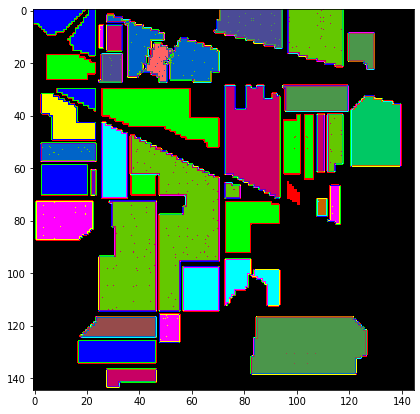

In [500]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

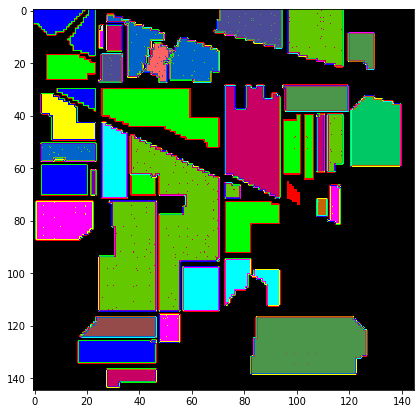

In [501]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [0]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)